In [1]:
# Install "numpy scipy matplotlib ipython pandas sympy" libraries via pip
import sys
!pip install --user numpy scipy pandas sympy

In [2]:
# Install scikit-learn via pip
import sys
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python2.7/dist-packages


In [3]:
# Install themis-ml via pip
# If this does not work, then you can install this library manually: try forllowing steps from your own terminal
# cd <to this directory>
# sudo python themis-ml/setup.py build
# sudo python themis-ml/setup.py install

import sys
!pip install --user themis-ml

In [1]:
#################################################
# Importing all libraries
#################################################

from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from themis_ml.preprocessing.relabelling import Relabeller
from themis_ml.meta_estimators import FairnessAwareMetaEstimator
from themis_ml.linear_model.counterfactually_fair_models import LinearACFClassifier
from themis_ml.postprocessing.reject_option_classification import SingleROClassifier
from themis_ml import datasets
from themis_ml.datasets.german_credit_data_map import preprocess_german_credit_data
import util as u

In [2]:
german_credit = datasets.german_credit(True)
german_credit[
    ["credit_risk", "purpose", "age_in_years", "foreign_worker"]].head()

,credit_risk,purpose,age_in_years,foreign_worker
0,1,radio/television,67,1
1,0,radio/television,22,1
2,1,education,49,1
3,1,furniture/equipment,45,1
4,0,car_(new),53,1


In [3]:
german_credit_preprocessed = (
    preprocess_german_credit_data(german_credit)
    # the following binary variable indicates whether someone is female or
    # not since the unique values in `personal_status` are:
    # 'personal_status_and_sex_female_divorced/separated/married'
    # 'personal_status_and_sex_male_divorced/separated'
    # 'personal_status_and_sex_male_married/widowed'
    # 'personal_status_and_sex_male_single'
    .assign(female=lambda df:
            df["personal_status_and_sex_female_divorced/separated/married"])
    # we're going to hypothesize here that young people, aged below 25,
    # might be  considered to have bad credit risk moreso than other groups
    .assign(age_below_25=lambda df: df["age_in_years"] <= 25)
)

In [4]:
print 'credit_risk'
credit_risk = german_credit_preprocessed.credit_risk
credit_risk.value_counts()

credit_risk


1    700
0    300
Name: credit_risk, dtype: int64

In [5]:
print 'female'
is_female = german_credit_preprocessed.female
is_female.value_counts()

female


0    690
1    310
Name: female, dtype: int64

In [6]:
print 'foreign'
is_foreign = german_credit_preprocessed.foreign_worker
is_foreign.value_counts()

foreign


1    963
0     37
Name: foreign_worker, dtype: int64

In [7]:
print 'age_below_25'
age_below_25 = german_credit_preprocessed.age_below_25
age_below_25.value_counts()

age_below_25


False    810
True     190
Name: age_below_25, dtype: int64

In [8]:
# specify feature set. Note that we're excluding the `is_female`
# and `age_below_25` columns that we created above.
feature_set_1 = [
    'duration_in_month',
    'credit_amount',
    'installment_rate_in_percentage_of_disposable_income',
    'present_residence_since',
    'age_in_years',
    'number_of_existing_credits_at_this_bank',
    'number_of_people_being_liable_to_provide_maintenance_for',
    'status_of_existing_checking_account',
    'savings_account/bonds',
    'present_employment_since',
    'job',
    'telephone',
    'foreign_worker',
    'credit_history_all_credits_at_this_bank_paid_back_duly',
    'credit_history_critical_account/other_credits_existing_not_at_this_bank',
    'credit_history_delay_in_paying_off_in_the_past',
    'credit_history_existing_credits_paid_back_duly_till_now',
    'credit_history_no_credits_taken/all_credits_paid_back_duly',
    'purpose_business',
    'purpose_car_(new)',
    'purpose_car_(used)',
    'purpose_domestic_appliances',
    'purpose_education',
    'purpose_furniture/equipment',
    'purpose_others',
    'purpose_radio/television',
    'purpose_repairs',
    'purpose_retraining',
    'personal_status_and_sex_female_divorced/separated/married',
    'personal_status_and_sex_male_divorced/separated',
    'personal_status_and_sex_male_married/widowed',
    'personal_status_and_sex_male_single',
    'other_debtors/guarantors_co-applicant',
    'other_debtors/guarantors_guarantor',
    'other_debtors/guarantors_none',
    'property_building_society_savings_agreement/life_insurance',
    'property_car_or_other',
    'property_real_estate',
    'property_unknown/no_property',
    'other_installment_plans_bank',
    'other_installment_plans_none',
    'other_installment_plans_stores',
    'housing_for free',
    'housing_own',
    'housing_rent',
]

In [9]:
#################################################
# Case 1: Baseline
#################################################

# training and target data
X = german_credit_preprocessed[feature_set_1].values
y = german_credit_preprocessed["credit_risk"].values
s_female = german_credit_preprocessed["female"].values
s_foreign = german_credit_preprocessed["foreign_worker"].values
s_age_below_25 = german_credit_preprocessed["age_below_25"].values

estimators = u.get_estemators()

experiment_baseline_female = u.cross_validation_experiment(estimators, X, y, s_female, "female")
experiment_baseline_foreign = u.cross_validation_experiment(estimators, X, y, s_foreign, "foreign_worker")
experiment_baseline_age_below_25 = u.cross_validation_experiment(estimators, X, y, s_age_below_25, "age_below_25")

Training model LogisticRegression with s=female
-----------------------------------------------
Training model DecisionTree with s=female
-----------------------------------------
Training model RandomForest with s=female
-----------------------------------------
Training model LogisticRegression with s=foreign_worker
-------------------------------------------------------


/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python2.7/dist-packages/themis_ml-0.0.4-py2.7.egg/themis_ml/metrics.py:40: RuntimeWarning: Mean of empty slice.
  mean_diff = y[s == 0].mean() - y[s == 1].mean()
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training model DecisionTree with s=foreign_worker
-------------------------------------------------
Training model RandomForest with s=foreign_worker
-------------------------------------------------
Training model LogisticRegression with s=age_below_25
-----------------------------------------------------
Training model DecisionTree with s=age_below_25
-----------------------------------------------
Training model RandomForest with s=age_below_25
-----------------------------------------------


In [10]:
experiment_baseline = u.generate_summary(experiment_baseline_female, experiment_baseline_foreign, experiment_baseline_age_below_25)
print experiment_baseline[1]

                                                   auc  mean_diff
protected_class estimator          fold_type                     
age_below_25    DecisionTree       test       0.702824   0.178503
                LogisticRegression test       0.672467   0.323023
                RandomForest       test       0.785714   0.257573
female          DecisionTree       test       0.703138   0.076940
                LogisticRegression test       0.672467   0.095351
                RandomForest       test       0.787790   0.098244
foreign_worker  DecisionTree       test       0.685748   0.183351
                LogisticRegression test       0.672467   0.285688
                RandomForest       test       0.788343   0.225916


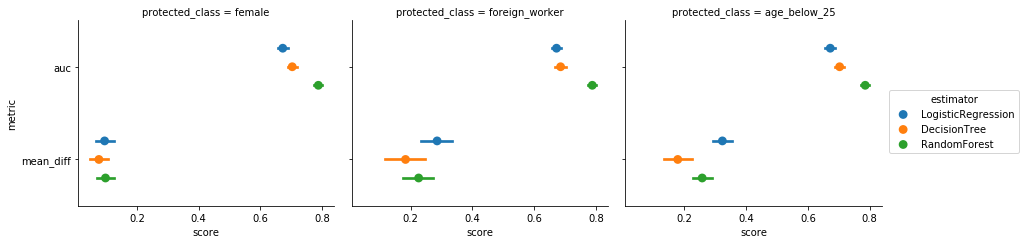

In [11]:
u.plot_experiment_results(experiment_baseline[0])

In [12]:
#################################################
# Naive Fairness-aware Approach: Remove Protected Class
#################################################

# create feature sets that remove variables with protected class information
feature_set_no_sex = [
    f for f in feature_set_1 if
    f not in [
        'personal_status_and_sex_female_divorced/separated/married',
        'personal_status_and_sex_male_divorced/separated',
        'personal_status_and_sex_male_married/widowed',
        'personal_status_and_sex_male_single']]
feature_set_no_foreign = [f for f in feature_set_1 if f != "foreign_worker"]
feature_set_no_age = [f for f in feature_set_1 if f != "age_in_years"]

# training and target data
X_no_sex = german_credit_preprocessed[feature_set_no_sex].values
X_no_foreign = german_credit_preprocessed[feature_set_no_foreign].values
X_no_age = german_credit_preprocessed[feature_set_no_age].values

experiment_naive_female = u.cross_validation_experiment(estimators, X_no_sex, y, s_female, "female")
experiment_naive_foreign = u.cross_validation_experiment(estimators, X_no_foreign, y, s_foreign, "foreign_worker")
experiment_naive_age_below_25 = u.cross_validation_experiment(estimators, X_no_age, y, s_age_below_25, "age_below_25")

Training model LogisticRegression with s=female
-----------------------------------------------
Training model DecisionTree with s=female
-----------------------------------------
Training model RandomForest with s=female
-----------------------------------------
Training model LogisticRegression with s=foreign_worker
-------------------------------------------------------
Training model DecisionTree with s=foreign_worker
-------------------------------------------------
Training model RandomForest with s=foreign_worker
-------------------------------------------------
Training model LogisticRegression with s=age_below_25
-----------------------------------------------------
Training model DecisionTree with s=age_below_25
-----------------------------------------------
Training model RandomForest with s=age_below_25
-----------------------------------------------


In [13]:
experiment_naive = u.generate_summary(experiment_naive_female, experiment_naive_foreign, experiment_naive_age_below_25)
print experiment_naive[1]

                                                   auc  mean_diff
protected_class estimator          fold_type                     
age_below_25    DecisionTree       test       0.695267   0.107387
                LogisticRegression test       0.683248   0.112415
                RandomForest       test       0.787143   0.183204
female          DecisionTree       test       0.696695   0.057173
                LogisticRegression test       0.671381   0.075551
                RandomForest       test       0.789638   0.068614
foreign_worker  DecisionTree       test       0.685090   0.166644
                LogisticRegression test       0.672362   0.285686
                RandomForest       test       0.786476   0.201458


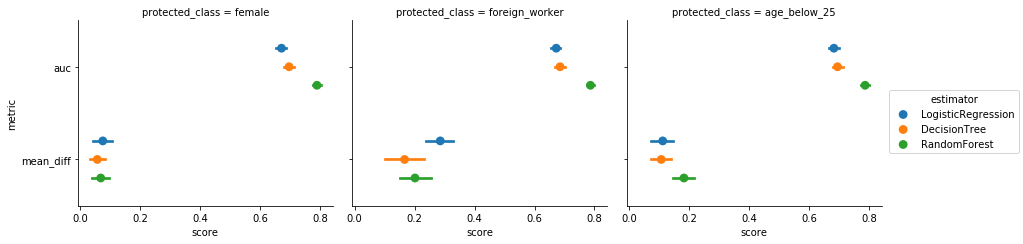

In [14]:
u.plot_experiment_results(experiment_naive[0])

In [15]:
#################################################
# Fairness-aware Method: Relabelling
#################################################

# here we use the relabeller class to create new y vectors for each of the
# protected class contexts.

# we also use the FairnessAwareMetaEstimator as a convenience class to
# compose together different fairness-aware methods. This wraps around the
# estimators that we defined in the previous
relabeller = Relabeller()
relabelling_estimators = [
    (name, FairnessAwareMetaEstimator(e, relabeller=relabeller))
    for name, e in estimators]

experiment_relabel_female = u.cross_validation_experiment(relabelling_estimators, X_no_sex, y, s_female, "female")
experiment_relabel_foreign = u.cross_validation_experiment(relabelling_estimators, X_no_foreign, y, s_foreign, "foreign_worker")
experiment_relabel_age_below_25 = u.cross_validation_experiment(relabelling_estimators, X_no_age, y, s_age_below_25, "age_below_25")

Training model LogisticRegression with s=female
-----------------------------------------------
Training model DecisionTree with s=female
-----------------------------------------
Training model RandomForest with s=female
-----------------------------------------
Training model LogisticRegression with s=foreign_worker
-------------------------------------------------------
Training model DecisionTree with s=foreign_worker
-------------------------------------------------
Training model RandomForest with s=foreign_worker
-------------------------------------------------
Training model LogisticRegression with s=age_below_25
-----------------------------------------------------
Training model DecisionTree with s=age_below_25
-----------------------------------------------
Training model RandomForest with s=age_below_25
-----------------------------------------------


In [16]:
experiment_relabel = u.generate_summary(experiment_relabel_female, experiment_relabel_foreign, experiment_relabel_age_below_25)
print experiment_relabel[1]

                                                   auc  mean_diff
protected_class estimator          fold_type                     
age_below_25    DecisionTree       test       0.699481   0.063719
                LogisticRegression test       0.678381   0.077014
                RandomForest       test       0.778162   0.109419
female          DecisionTree       test       0.709552   0.032335
                LogisticRegression test       0.669095   0.058545
                RandomForest       test       0.782276   0.054762
foreign_worker  DecisionTree       test       0.698781   0.093680
                LogisticRegression test       0.671562   0.283398
                RandomForest       test       0.786000   0.184606


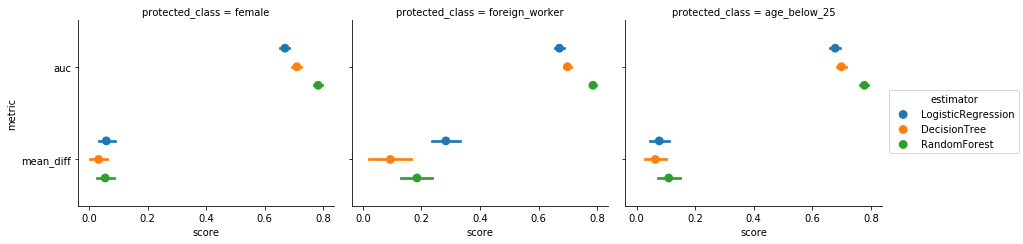

In [17]:
u.plot_experiment_results(experiment_relabel[0])

In [18]:
#################################################
# Fairness-aware Method: Additive Counterfactually Fair Model
#################################################

LINEAR_REG = LinearRegression()
DECISION_TREE_REG = DecisionTreeRegressor(max_depth=10, min_samples_leaf=10)
RANDOM_FOREST_REG = RandomForestRegressor(
    n_estimators=50, max_depth=10, min_samples_leaf=10)

# use the estimators defined above to define the linear additive
# counterfactually fair models
linear_acf_estimators = [
    (name, LinearACFClassifier(
         target_estimator=e,
         binary_residual_type="absolute"))
    for name, e in estimators]

experiment_acf_female = u.cross_validation_experiment(linear_acf_estimators, X_no_sex, y, s_female, "female")
experiment_acf_foreign = u.cross_validation_experiment(linear_acf_estimators, X_no_foreign, y, s_foreign, "foreign_worker")
experiment_acf_age_below_25 = u.cross_validation_experiment(linear_acf_estimators, X_no_age, y, s_age_below_25, "age_below_25")

Training model LogisticRegression with s=female
-----------------------------------------------
Training model DecisionTree with s=female
-----------------------------------------
Training model RandomForest with s=female
-----------------------------------------
Training model LogisticRegression with s=foreign_worker
-------------------------------------------------------
Training model DecisionTree with s=foreign_worker
-------------------------------------------------
Training model RandomForest with s=foreign_worker
-------------------------------------------------
Training model LogisticRegression with s=age_below_25
-----------------------------------------------------
Training model DecisionTree with s=age_below_25
-----------------------------------------------
Training model RandomForest with s=age_below_25
-----------------------------------------------


In [19]:
experiment_acf = u.generate_summary(experiment_acf_female, experiment_acf_foreign, experiment_acf_age_below_25)
print experiment_acf[1]

                                                   auc  mean_diff
protected_class estimator          fold_type                     
age_below_25    DecisionTree       test       0.688067   0.221431
                LogisticRegression test       0.668181  -0.033848
                RandomForest       test       0.784752   0.386766
female          DecisionTree       test       0.684752   0.115024
                LogisticRegression test       0.670000   0.028742
                RandomForest       test       0.784429   0.141616
foreign_worker  DecisionTree       test       0.696362   0.299007
                LogisticRegression test       0.667190   0.117529
                RandomForest       test       0.787257   0.352886


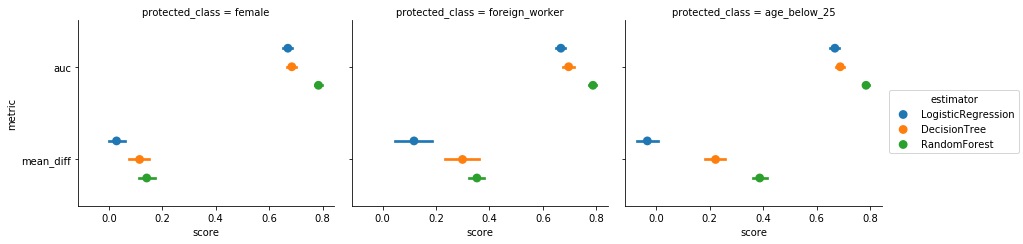

In [20]:
u.plot_experiment_results(experiment_acf[0])

In [21]:
#################################################
# Reject-option Classification
#################################################

# use the estimators defined above to define the linear additive
# counterfactually fair models
single_roc_clf_estimators = [
    (name, SingleROClassifier(estimator=e))
    for name, e in estimators]

experiment_single_roc_female = u.cross_validation_experiment(single_roc_clf_estimators, X_no_sex, y, s_female, "female")
experiment_single_roc_foreign = u.cross_validation_experiment(single_roc_clf_estimators, X_no_foreign, y, s_foreign, "foreign_worker")
experiment_single_roc_age_below_25 = u.cross_validation_experiment(single_roc_clf_estimators, X_no_age, y, s_age_below_25, "age_below_25")

Training model LogisticRegression with s=female
-----------------------------------------------
Training model DecisionTree with s=female
-----------------------------------------
Training model RandomForest with s=female
-----------------------------------------
Training model LogisticRegression with s=foreign_worker
-------------------------------------------------------
Training model DecisionTree with s=foreign_worker
-------------------------------------------------
Training model RandomForest with s=foreign_worker
-------------------------------------------------
Training model LogisticRegression with s=age_below_25
-----------------------------------------------------
Training model DecisionTree with s=age_below_25
-----------------------------------------------
Training model RandomForest with s=age_below_25
-----------------------------------------------


In [22]:
experiment_single_roc = u.generate_summary(experiment_single_roc_female, experiment_single_roc_foreign, experiment_single_roc_age_below_25)
print experiment_single_roc[1]

                                                   auc  mean_diff
protected_class estimator          fold_type                     
age_below_25    DecisionTree       test       0.689048   0.110919
                LogisticRegression test       0.532400  -0.040909
                RandomForest       test       0.761276   0.108604
female          DecisionTree       test       0.690490   0.055103
                LogisticRegression test       0.619590  -0.037961
                RandomForest       test       0.766029   0.036707
foreign_worker  DecisionTree       test       0.706905   0.156914
                LogisticRegression test       0.619629   0.082053
                RandomForest       test       0.765914   0.140822


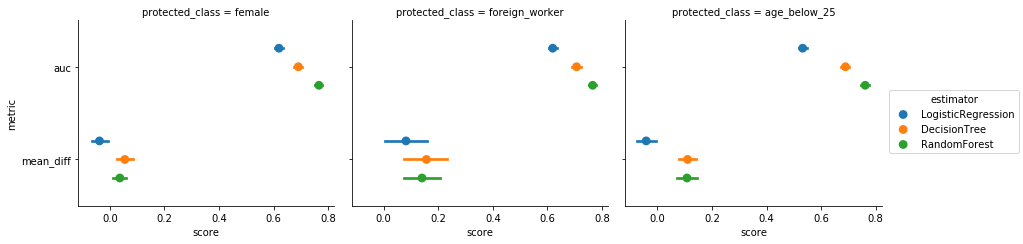

In [23]:
u.plot_experiment_results(experiment_single_roc[0])

In [24]:
#################################################
# Comparison
#################################################

compare_experiments = u.comparison(experiment_baseline[0], experiment_naive[0], experiment_relabel[0], experiment_acf[0], experiment_single_roc[0])

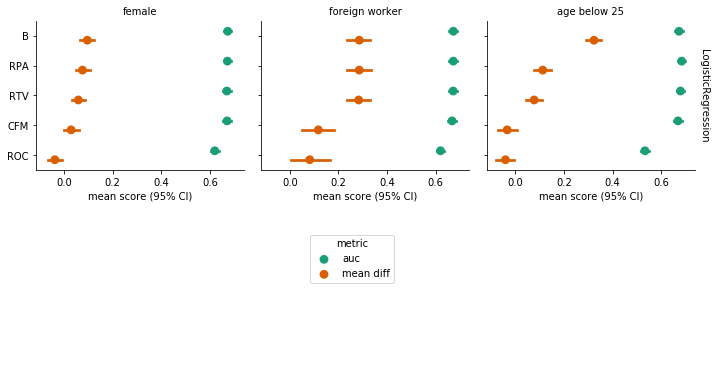

In [25]:
u.compare_experiment_results_multiple_model(compare_experiments.query("estimator == 'LogisticRegression'"))

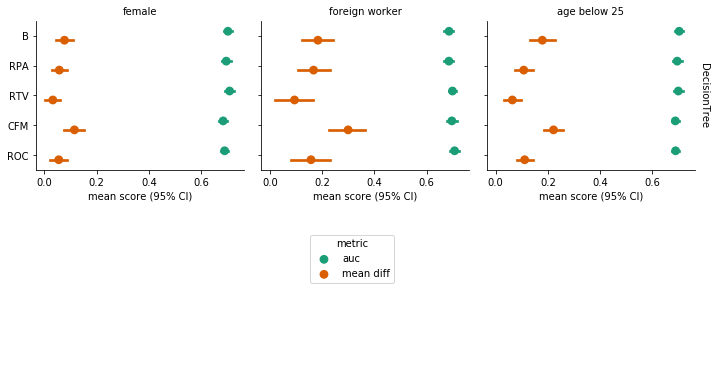

In [26]:
u.compare_experiment_results_multiple_model(compare_experiments.query("estimator == 'DecisionTree'"))

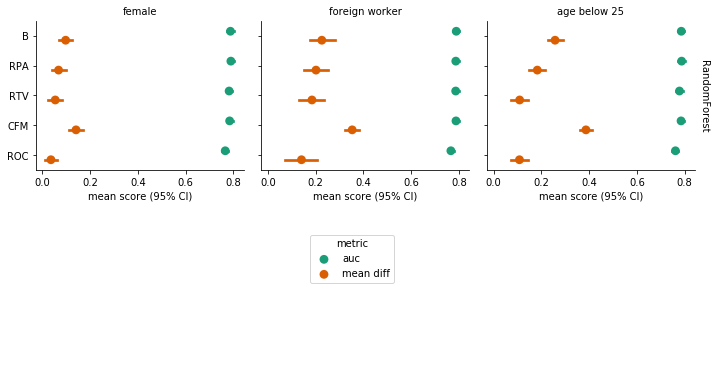

In [27]:
u.compare_experiment_results_multiple_model(compare_experiments.query("estimator == 'RandomForest'"))